# Исследование интернет-магазина «В один клик».

## 1 Шаг. Загрузка и изучение данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import phik

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import(
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
) 

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Загрузка датафрейма и преобразование столбца id в индексы
path1 = '/datasets/market_file.csv'
path2 = 'C:/Users/Kseno/Downloads/market_file.csv'

if os.path.exists(path1):
    market_file = pd.read_csv(path1, index_col = 'id')
elif os.path.exists(path2):
    market_file = pd.read_csv(path2, index_col = 'id')
else:
    print('Something is wrong')

market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_file.describe() # Общая информация о количественных признаках

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [6]:
market_file.describe(include='object') # Общая информация о категориальных признаках

,Покупательская активность,Тип сервиса,Разрешить сообщать,Популярная_категория
count,1300,1300,1300,1300
unique,2,3,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,914,962,330


In [7]:
market_file.info() # Общая информация о датафрейме 

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   object 
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит            

* в датафрейме `market_file` содержится 1300 строк и 13 столбцов;
* данные соответствуют описанию;
* названия столбцов нужно привести к змеиному регистру;
* пропусков в данных нет;
* типы данных во всех столбцах верные.

In [9]:
path1 = '/datasets/market_money.csv'
path2 = 'C:/Users/Kseno/Downloads/market_money.csv'

if os.path.exists(path1):
    market_money = pd.read_csv(path1, index_col = 'id')
elif os.path.exists(path2):
    market_money = pd.read_csv(path2, index_col = 'id')
else:
    print('Something is wrong')

market_money.head()

,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6


In [10]:
market_money.describe()

,Выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


In [11]:
market_money.describe(include='object')

,Период
count,3900
unique,3
top,препредыдущий_месяц
freq,1300


In [12]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3900 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Период   3900 non-null   object 
 1   Выручка  3900 non-null   float64
dtypes: float64(1), object(1)
memory usage: 91.4+ KB


* датафрейм `market_money` содержит 3900 строк и 3 столбца;
* пропусков в данных нет;
* типы данных во всех столбцах верные;
* названия столбцов нужно привести к змеиному регистру;
* данные соответсвуют описанию;
* в столбце `Выручка` имеется аномальное макимальное значение, стоит его внимательнее рассмотреть при Исследовательском анализе.

In [14]:
path1 = '/datasets/market_time.csv'
path2 = 'C:/Users/Kseno/Downloads/market_time.csv'

if os.path.exists(path1):
    market_time = pd.read_csv(path1, index_col = 'id')
elif os.path.exists(path2):
    market_time = pd.read_csv(path2, index_col = 'id')
else:
    print('Something is wrong')

market_time.head()

,Период,минут
id,,
215348,текущий_месяц,14
215348,предыдцщий_месяц,13
215349,текущий_месяц,10
215349,предыдцщий_месяц,12
215350,текущий_месяц,13


In [15]:
market_time.describe()

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


In [16]:
market_time.describe(include='object')

,Период
count,2600
unique,2
top,текущий_месяц
freq,1300


In [17]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2600 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Период  2600 non-null   object
 1   минут   2600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB


* датафрейм `market_time` содержит 2600 строк и 3 столбца;
* пропусков в данных нет;
* в столбце `Период` нужно исправить опечатку в названии категории Предыдущий месяц;
* названия столбцов нужно привести к змеиному регистру;
* типы данных во всех столбцах верные;
* данные соответствуют описанию.

In [19]:
path1 = '/datasets/money.csv'
path2 = 'C:/Users/Kseno/Downloads/money.csv'

if os.path.exists(path1):
    money = pd.read_csv(path1, index_col = 'id', sep=';', decimal=',')
elif os.path.exists(path2):
    money = pd.read_csv(path2, index_col = 'id', sep=';', decimal=',')
else:
    print('Something is wrong')

money.head()

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


In [20]:
money.describe()

,Прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


In [21]:
money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


* в датафрейме `money` содержится 1300 строк и 2 столбца;
* пропусков в данных нет;
* типы данных верные;
* названия столбцов нужно привести к змеиному регистру;
* данные соответствуют описанию.

**Итоги раздела:**
* в датафрейме `market_file` содержится 1300 строк и 13 столбцов;
* датафрейм `market_money` содержит 3900 строк и 3 столбца, так же в столбце Выручка имеется аномальное макимальное значение, стоит его внимательнее рассмотреть при Исследовательском анализе;
* датафрейм `market_time` содержит 2600 строк и 3 столбца, так же в столбце Период нужно исправить опечатку в названии категории Предыдущий месяц;
* в датафрейме `money` содержится 1300 строк и 2 столбца;
* пропусков во всех данных нет;
* данные и их типы соответствуют описанию;
* названия столбцов нужно привести к стандартному.

## 2 Шаг. Предобработка данных

In [25]:
# Приведение названий столбцов к верблюжьему регистру
market_file = market_file.rename(
    columns={
        'Покупательская активность':'Покупательская_активность', 
        'Тип сервиса':'Тип_сервиса',
        'Разрешить сообщать':'Разрешить_сообщать',
    }
)

In [26]:
# Приведение категориальных данных в столбце к нижнему регистру для избежания ошибок и проверка на неявные дубликаты
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].str.lower()
market_file['Покупательская_активность'].unique()

array(['снизилась', 'прежний уровень'], dtype=object)

In [27]:
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].str.lower()
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [28]:
# Удаление неявных дубликатов
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт', regex=True)
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [29]:
market_file['Популярная_категория'] = market_file['Популярная_категория'].str.lower()
market_file['Популярная_категория'].unique()

array(['товары для детей', 'домашний текстиль', 'косметика и аксесуары',
       'техника для красоты и здоровья', 'кухонная посуда',
       'мелкая бытовая техника и электроника'], dtype=object)

In [30]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [31]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдyщий_месяц', regex=True)
market_time['Период'].unique()

array(['текущий_месяц', 'предыдyщий_месяц'], dtype=object)

In [32]:
for df in [market_file, market_time, market_money, money]:
    df.columns = df.columns.str.lower()

**Итоги раздела:**
* названия столбцов во всех датафреймах были приведены к змеиному регистру;
* категориальные данные были приведены к нижнему регистру;
* обнаружены и удалены неявные дубликаты в датафрейме `market_file`;
* исправлена опечатка в названии категории в датафрейме `market_time`.

## 3 Шаг. Исследовательский анализ данных

### 3.1 Анализ датафрейма market_file

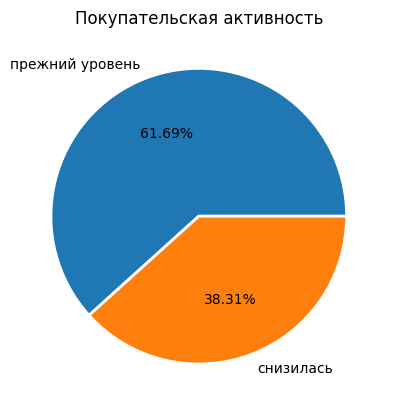

In [36]:
aktiv = market_file['покупательская_активность'].value_counts()
plt.pie(aktiv, labels=aktiv.index, autopct='%1.2f%%', wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'})
plt.title('Покупательская активность')
plt.show()

Покупательская активность снизилась у почти 40% покупателей за прошедший период.

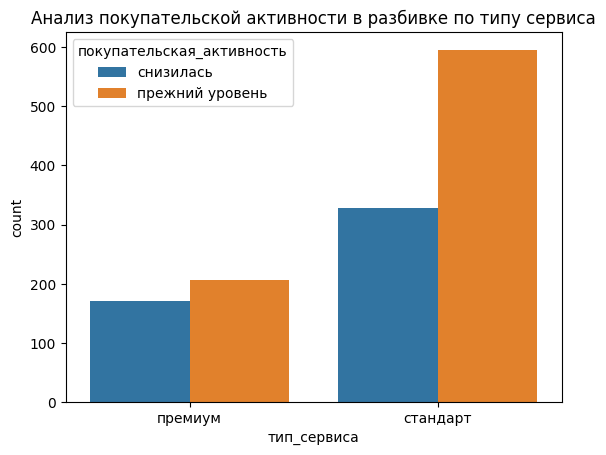

In [38]:
sns.countplot(data=market_file, x='тип_сервиса', hue='покупательская_активность')
plt.title('Анализ покупательской активности в разбивке по типу сервиса')
plt.show()

Покупательская активность снизилась у практически половины пользователей Премиум сегмента, стоит внимательней изучить причину оттока покупателей с Премиум подпиской.

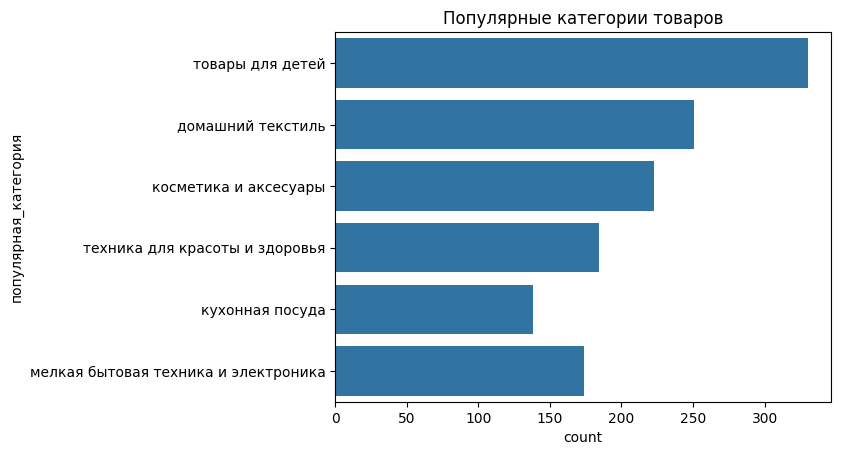

In [40]:
sns.countplot(data=market_file, y='популярная_категория')
plt.title('Популярные категории товаров')
plt.show()

В топе популярных категорий находятся Товары для детей, Домашний текстиль и Косметика и аксессуары.

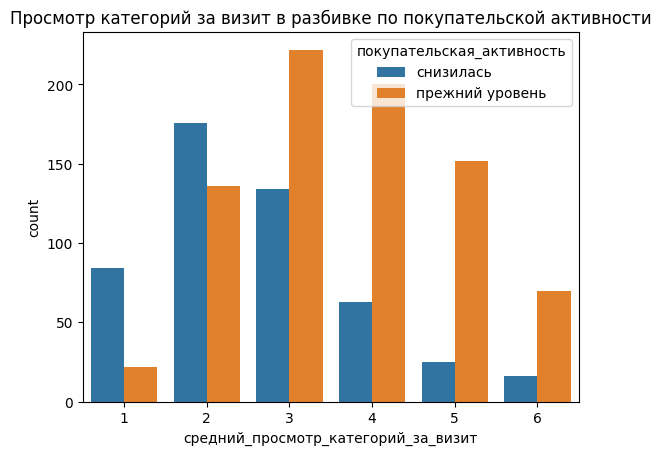

In [42]:
sns.countplot(data=market_file, x='средний_просмотр_категорий_за_визит', hue='покупательская_активность')
plt.title('Просмотр категорий за визит в разбивке по покупательской активности')
plt.show()

Посетители интернет-магазина с низкой покупательской активностью в основном просматривают 2-3 категории товаров за визит, а у тех, чей уровень остался прежним количество просматриваемых категорий в основном 3-5.

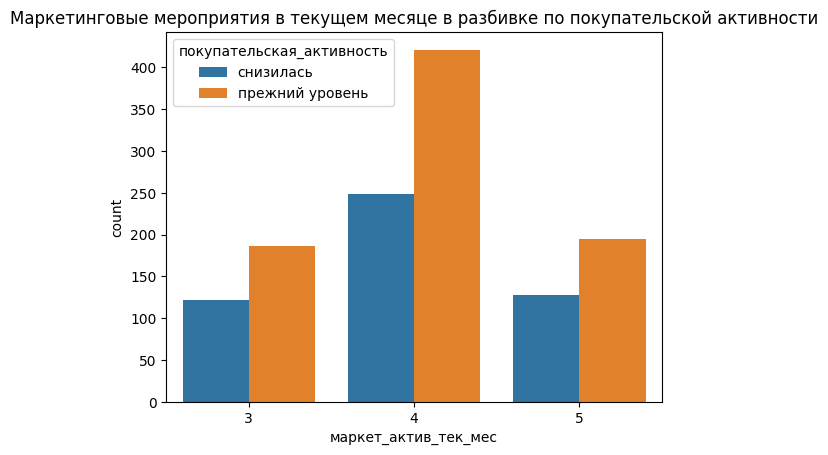

In [44]:
sns.countplot(data=market_file, x='маркет_актив_тек_мес', hue='покупательская_активность')
plt.title('Маркетинговые мероприятия в текущем месяце в разбивке по покупательской активности')
plt.show()

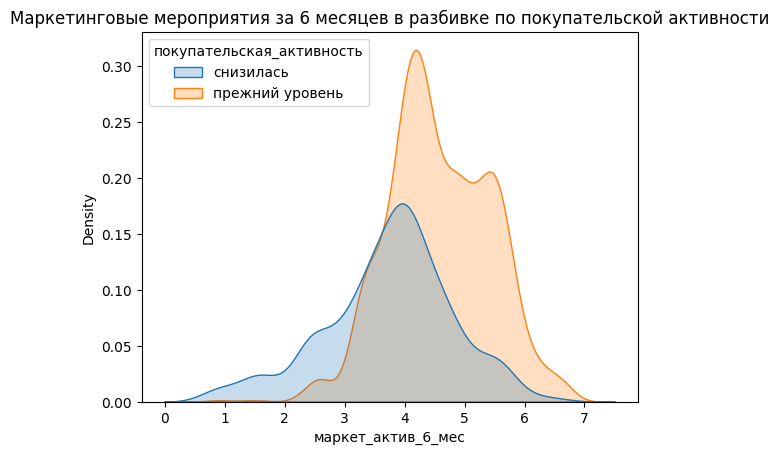

In [45]:
sns.kdeplot(data=market_file, x='маркет_актив_6_мес', hue='покупательская_активность', fill=True)
plt.title('Маркетинговые мероприятия за 6 месяцев в разбивке по покупательской активности')
plt.show()

Можно сделать вывод, что у покупателей со снизившейся активностью было меньше маркетинговых мероприятий.

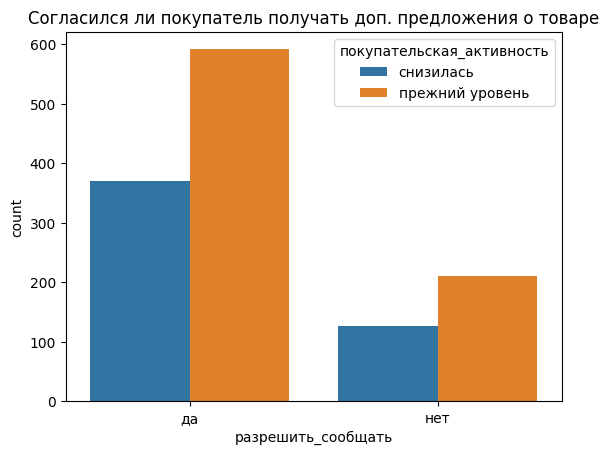

In [47]:
sns.countplot(data=market_file, x='разрешить_сообщать', hue='покупательская_активность')
plt.title('Согласился ли покупатель получать доп. предложения о товаре')
plt.show()

В целом среди тех, кто согласился на получение дополнительной информации и товарах и тех, кто отказался, одинаковая доля покупателей со снизившейся активностью.

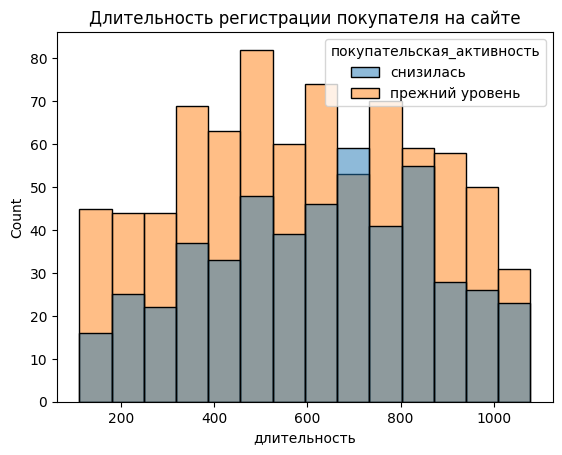

In [49]:
sns.histplot(data=market_file, x='длительность', hue='покупательская_активность')
plt.title('Длительность регистрации покупателя на сайте')
plt.show()

Происходит значительный отток старых клиентов, тех кто зарегистрировался на сайте около 700 и 800 дней назад.

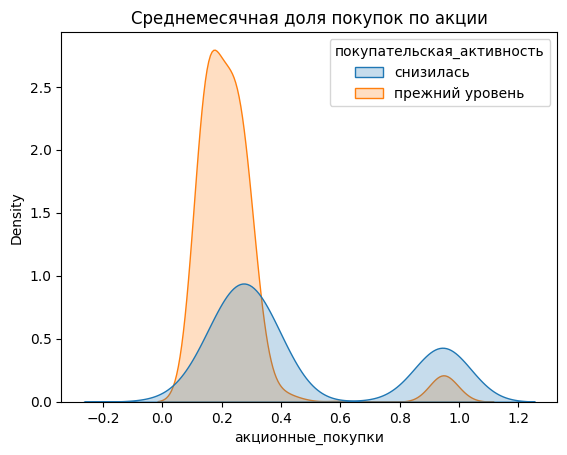

In [51]:
sns.kdeplot(data=market_file, x='акционные_покупки', hue='покупательская_активность', fill=True)
plt.title('Среднемесячная доля покупок по акции')
plt.show()

Покупатели со снизившейся активностью совершают много покупок по акции.

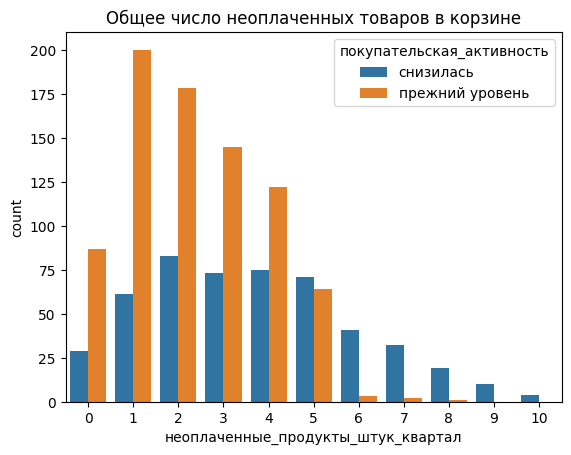

In [53]:
sns.countplot(data=market_file, x='неоплаченные_продукты_штук_квартал', hue='покупательская_активность')
plt.title('Общее число неоплаченных товаров в корзине')
plt.show()

Среди покупателей со снизившейся активность большая доля тех, кто оставляет 5 и более неоплаченных товаров в корзине. Начиная с 6 неоплаченных товаров практически все покупаетли принадлежат к категории Снизившейся активности.

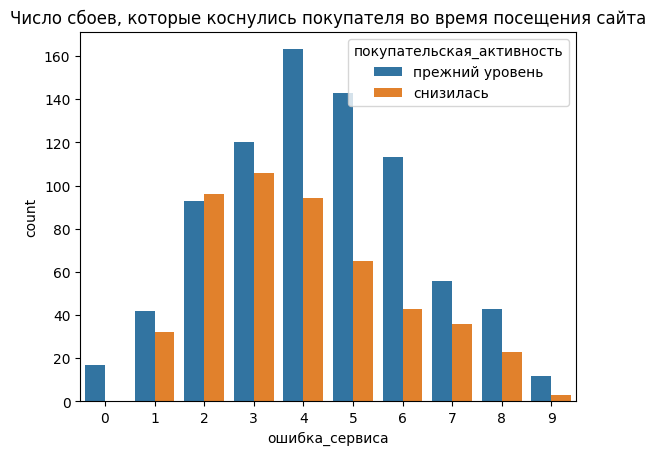

In [55]:
sns.countplot(data=market_file, x='ошибка_сервиса', hue='покупательская_активность')
plt.title('Число сбоев, которые коснулись покупателя во время посещения сайта')
plt.show()

Почти у половины пользователей столкнувшихся с 2 или 3 ошибками сервиса упала покупательская активность. Дальнейший рост количества ошибок не влияет на покупательскую активность.

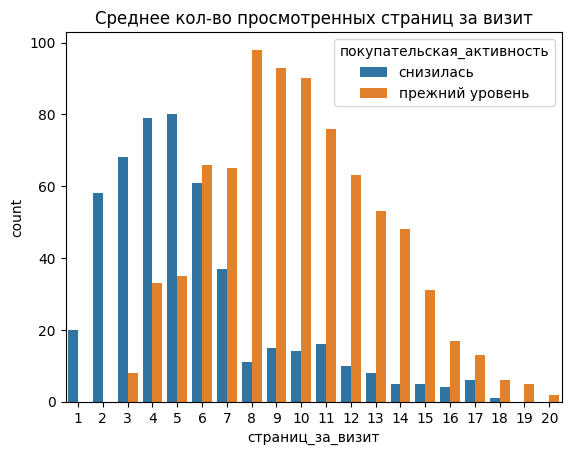

In [57]:
sns.countplot(data=market_file, x='страниц_за_визит', hue='покупательская_активность')
plt.title('Среднее кол-во просмотренных страниц за визит')
plt.show()

Пользователи со снизившейся активностью просматривают меньше страниц за визит, чем пользователи оставшиеся на прежнем уровне.

### 3.2 Анализ датафрейма market_money

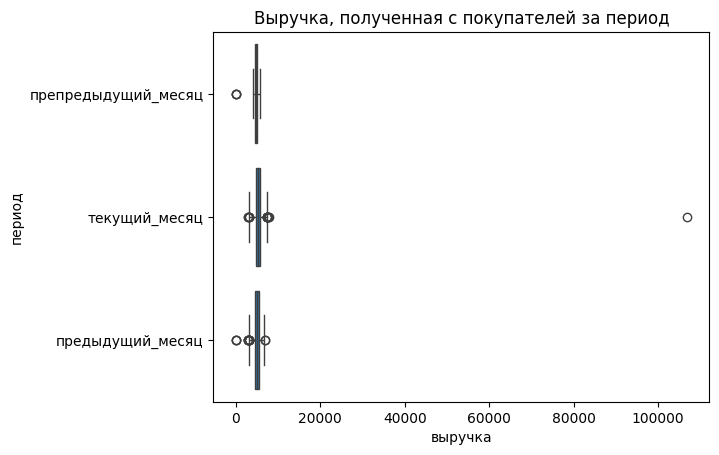

In [60]:
sns.boxplot(data=market_money, x='выручка', y='период')
plt.title('Выручка, полученная с покупателей за период')
plt.show()

Выручка от одного клиента в текущем месяце более 100000 скорее всего является выбросом, а так как некоторые модели МО чувствительны к выбросам, то стоит его удалить.

In [62]:
market_money = market_money.query('выручка <= 80000')

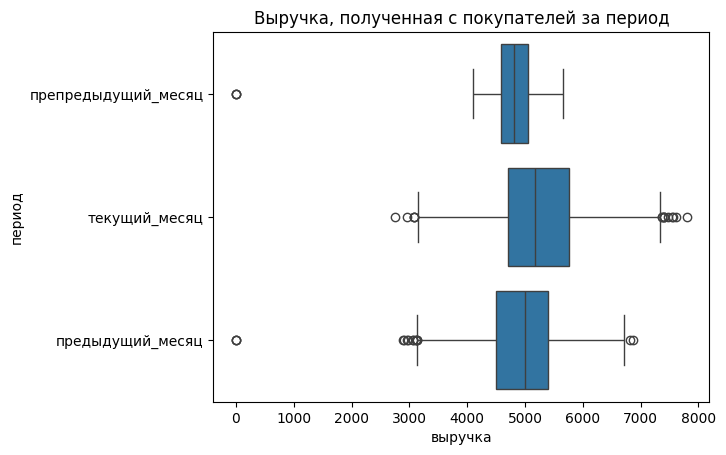

In [63]:
sns.boxplot(data=market_money, x='выручка', y='период')
plt.title('Выручка, полученная с покупателей за период')
plt.show()

В целом выручка от клиентов растёт каждый месяц. Так же за Препредыдущий и предыдущий месяц зафиксированы клиенты с нулевой выручкой.

### 3.3 Анализ датафрейма market_time

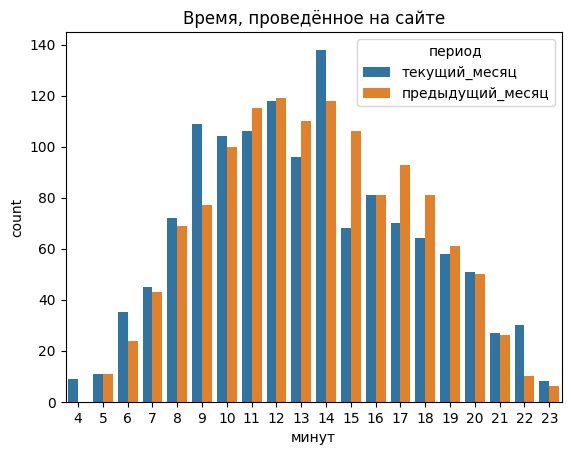

In [66]:
sns.countplot(data=market_time, x='минут', hue='период', fill=True)
plt.title('Время, проведённое на сайте')
plt.show()

Пользователи проводили на сайте практически одинаковое время в текущем и предыдущем месяце.

### 3.4 Анализ датафрейма money

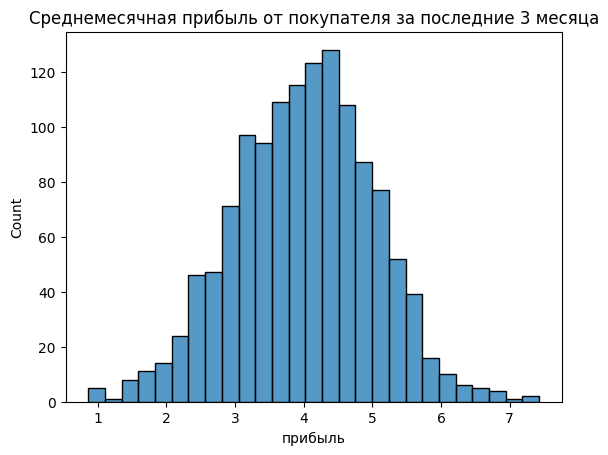

In [69]:
sns.histplot(money['прибыль'])
plt.title('Среднемесячная прибыль от покупателя за последние 3 месяца')
plt.show()

У компании имеется нормально распределённая прибыль.

**Итоги раздела:**
* покупательская активность снизилась у почти 40% покупателей за прошедший период;
* практически у половины пользователей Премиум снизилась покупательская активность;
* в топе популярных категорий находятся Товары для детей, Домашний текстиль и Косметика и аксессуары;
* пользователи с низкой покупательской активностью просматривают меньше категорий товаров за визит(всего 2-3), в отличие от обычных пользователей(в основном 3-5 категорий);
* у покупателей со снизившейся активностью было меньше маркетинговых мероприятий;
* согласие или отказ от получения рекламы не вляет на покупательскую активность;
* почти у половины пользователей столкнувшихся с 2 или 3 ошибками сервиса упала покупательская активность;
* пользователи со снизившейся активностью просматривают меньше страниц за визит, чем пользователи оставшиеся на прежнем уровне;
* был обнаружен и удалён выброс в датафейме `market_money`;
* в целом выручка от клиентов растёт каждый месяц;
* пользователи проводили на сайте практически одинаковое время в текущем и предыдущем месяце;
* у компании имеется нормально распределённая прибыль.

## 4 Шаг. Объединение таблиц

In [73]:
# Группировка таблицы по id и Периоду
time_group = market_time.pivot_table(index=['id'], columns=["период"])
time_group.columns = ['минут_предыдyщий_месяц', 'минут_текущий_месяц']
time_group.head()

,минут_предыдyщий_месяц,минут_текущий_месяц
id,,
215348,13.0,14.0
215349,12.0,10.0
215350,8.0,13.0
215351,11.0,13.0
215352,8.0,11.0


In [74]:
# Удаление пользователей не совершавших покупки в ближайшие 3 месяца и группировка по периоду
market_money = market_money.query('выручка > 0')
money_group = market_money.pivot_table(index=['id'], columns=["период"])
money_group.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
money_group.head()

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [75]:
# Объединение таблиц
all_df = market_file.join(money_group, on='id').join(time_group, on='id')
all_df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдyщий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,NaN,NaN,3293.1,13.0,14.0
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0


In [76]:
all_df.isna().sum() # Проверка на пропуски

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               3
выручка_препредыдущий_месяц            3
выручка_текущий_месяц                  1
минут_предыдyщий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [77]:
all_df = all_df.dropna() # Удаление пропусков

**Итоги раздела:**
* датафреймы `market_file`, `market_money` и `market_time` были объединены в один `all_df`;
* было обнаружено и удалено одно пропущенное значение.

## 5 Шаг. Корреляционный анализ

In [80]:
corr_df = all_df.phik_matrix(interval_cols=[
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки', 
    'выручка_за_предпредыдущий_месяц', 
    'выручка_за_предыдущий_месяц', 
    'выручка_за_текущий_месяц'
    ]
)
corr_df

C:\Users\kseno\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable выручка_предыдущий_месяц is large: 1120. Are you sure this is not an interval variable? Analysis for pairs of variables including выручка_предыдущий_месяц can be slow.
  warnings.warn(
C:\Users\kseno\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable выручка_текущий_месяц is large: 1238. Are you sure this is not an interval variable? Analysis for pairs of variables including выручка_текущий_месяц can be slow.
  warnings.warn(


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдyщий_месяц,минут_текущий_месяц
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.405041,0.224154,0.747331,0.301379,0.429283,0.536188,0.604355,0.569983
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.113015,0.079515,0.087776,0.379224,0.323045,0.699786,0.121210,0.061764
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.162524,0.021839,0.097094,0.051464,0.316196,0.653203,0.063528,0.000000
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.217731,0.142401,0.376035,0.790422,0.562946,0.863855,0.322830,0.331480
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.142887,0.116946,0.000000,0.539872,0.320357,0.799798,0.166871,0.079883
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.128222,0.175608,0.128089,0.621090,0.419332,0.845452,0.046299,0.021117
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.246665,0.000000,0.350714,0.427464,0.611785,0.982252,0.314140,0.287292
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.254746,0.000000,0.177637,0.532015,0.242388,0.842773,0.218727,0.113774
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.334927,0.070315,0.293781,0.571934,0.000000,0.675929,0.219174,0.236298
неоплаченные_продукты_штук_квартал,0.405041,0.113015,0.162524,0.217731,0.142887,0.128222,0.246665,0.254746,0.334927,1.000000,0.000000,0.310843,0.913914,0.612363,0.912120,0.194298,0.158243


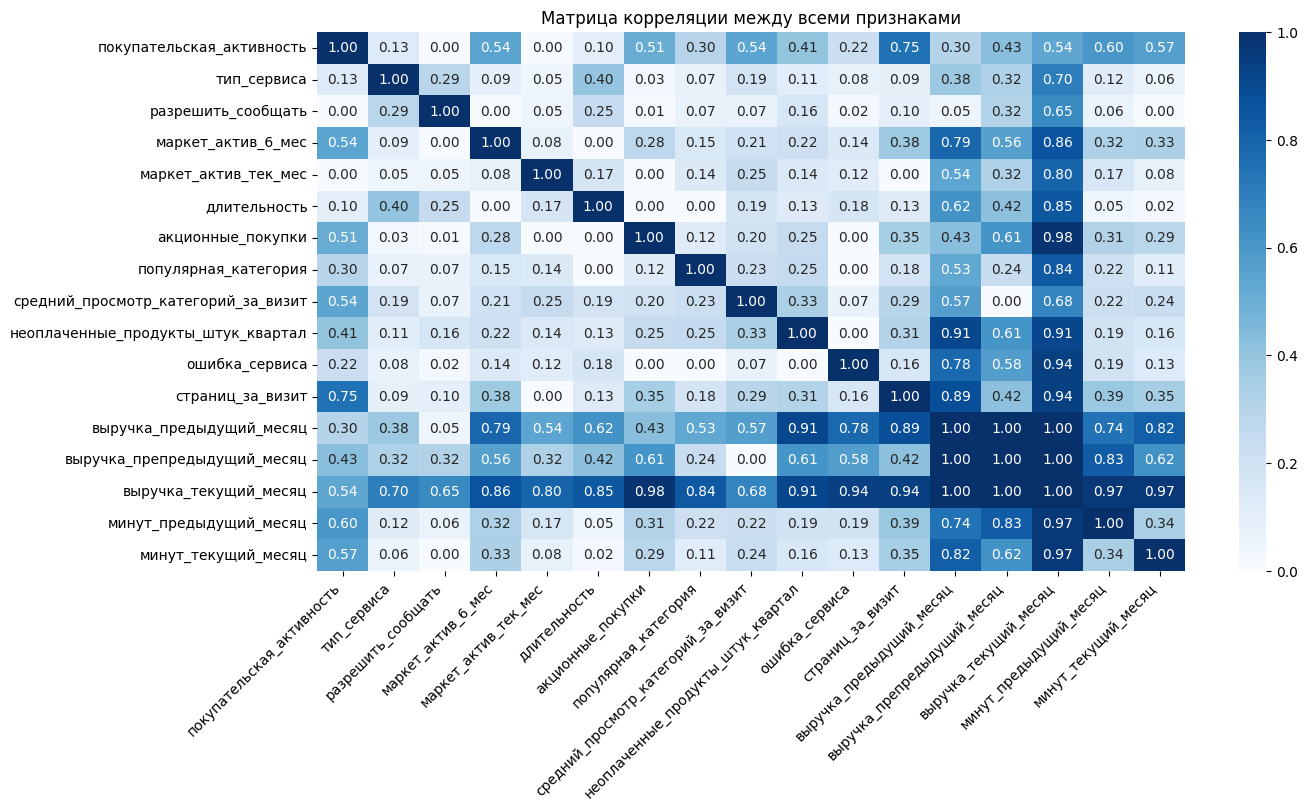

In [81]:
plt.figure(figsize=(14, 7))
heatmap = sns.heatmap(corr_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Матрица корреляции между всеми признаками')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha="right")
plt.show()

* Признак Выручка за текущий месяц имеет мультиколлинеарность с 8 признаками, при этом с целевым признаком корреляция средняя (0.54). Признак следует удалить.
* Признак Выручка предыдущий месяц имеет мультиколлинеарность с 4 признаками, при этом корреляция с целевым слабая (0.43). Признак так же следует удалить.

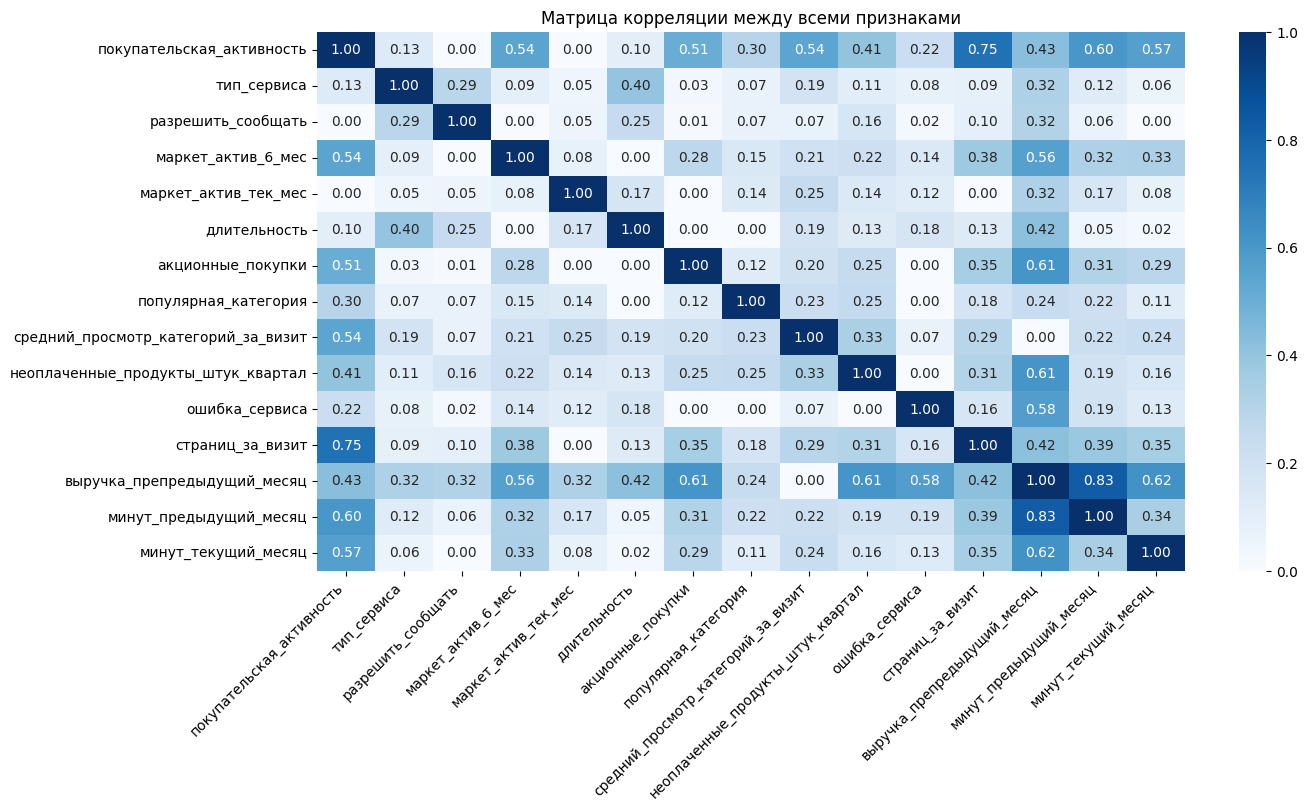

In [83]:
corr_df = all_df.drop(['выручка_текущий_месяц', 'выручка_предыдущий_месяц'], axis=1)
corr_df = corr_df.phik_matrix(interval_cols=[
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки', 
    'выручка_предпредыдущий_месяц'
    ]
)
plt.figure(figsize=(14, 7))
heatmap = sns.heatmap(corr_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Матрица корреляции между всеми признаками')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha="right")
plt.show()

Мультиколлинеарность между признаками устранена. Целевой признак Покупательская активность в целом не плохо коррелирует со входными признаками и только с двумя корреляция отсутствует.

**Итоги раздела:**
* выявлена мультиколлинеарность двух входных признаков Выручка за предыдущий месяц и Выручка за текущий месяц;
* мультиколлинеарные признаки удалены;
* целевой признак Покупательская активность в целом не плохо коррелирует со входными признаками и только с двумя корреляция отсутствует.

## 6 Шаг. Построение моделей с использованием пайплайнов

In [87]:
# Построение общего пайплайна для 4-х типов моделей МО с подбором гиперпараметров
X_train, X_test, y_train, y_test = train_test_split(
    all_df.drop(['покупательская_активность', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц'], axis=1),
    all_df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = all_df['покупательская_активность']
)

In [88]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [89]:
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
ohe_columns = ['популярная_категория']

In [90]:
num_columns = ['маркет_актив_6_мес', 
               'маркет_актив_тек_мес', 
               'длительность', 
               'акционные_покупки', 
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит',
               'выручка_препредыдущий_месяц',
               'минут_предыдyщий_месяц',
               'минут_текущий_месяц'
              ]

ohe_pipe = Pipeline(
    [('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[['премиум', 'стандарт'], ['да', 'нет']],
        handle_unknown='use_encoded_value', unknown_value=np.nan
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [91]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            probability=True
        )],
        'models__C': range(1, 5),
        'models__gamma': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    
]

In [92]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

В своём исследовании в качестве метрики я выберу ROC-AUC, так как она учитывает работу моделей при всех возможных значениях порогов классификации. И так как по запросу заказчика нельзя выделить наиболее критичный тип ошибок, то общая оценка их качества работы хорошо подойдёт.

In [94]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'models__gamma': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [95]:
# Вывод лучшей модели
best_model = randomized_search.best_estimator_
'Лучшая модель и её параметры:', best_model

('Лучшая модель и её параметры:',
 Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('ohe',
                                                   Pipeline(steps=[('simpleImputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore',
                                                                                  sparse_output=False))]),
                                                   ['популярная_категория']),
                                                  ('ord',
                                                   Pipeline(steps=[('simpleImputer_before_ord',
 

In [96]:
'Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_

('Метрика лучшей модели на кросс-валидации:', 0.8970727471272927)

In [97]:
y_pred = best_model.predict_proba(X_test)
f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred[:,1])}'

'Метрика ROC-AUC на тестовой выборке: 0.9182138090037617'

In [98]:
# Создание константной модели классификации
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_dummy[:, 1])
score

0.5

Метрика ROC-AUC на тестовой выборке у константной модели DummyClassifier составляет 0.5, то есть 50% верных предсказаний. У лучшей модели эта метрика составляет 92%, значит усилия по разработке и настройке модели были приложены не зря.

**Итог раздела:**
* лучшей моделью оказалась `Логистическая регрессия` с гиперпараметрами `C=3`, `penalty='l1'`, `solver='liblinear'`;
* Метрика ROC-AUC лучшей модели на кросс-валидации: 0.90;
* Метрика ROC-AUC лучшей модели на тестовой выборке: 0.92;
* Для проверки лучшей модели на адекватность была построена константная модель `DummyClassifier`, её метрика составила всего 0.5. Значит разработка и настройка моделей в пайплайне была проведена не зря.

## 7 Шаг. Анализ важности признаков

In [102]:
# Подготовка данных и построение общего графика важности признаков
model = randomized_search.best_estimator_.named_steps['models']
X_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(model, X_train)
X_test = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test = pd.DataFrame(X_test, columns=feature_names)
shap_values = explainer(X_test)

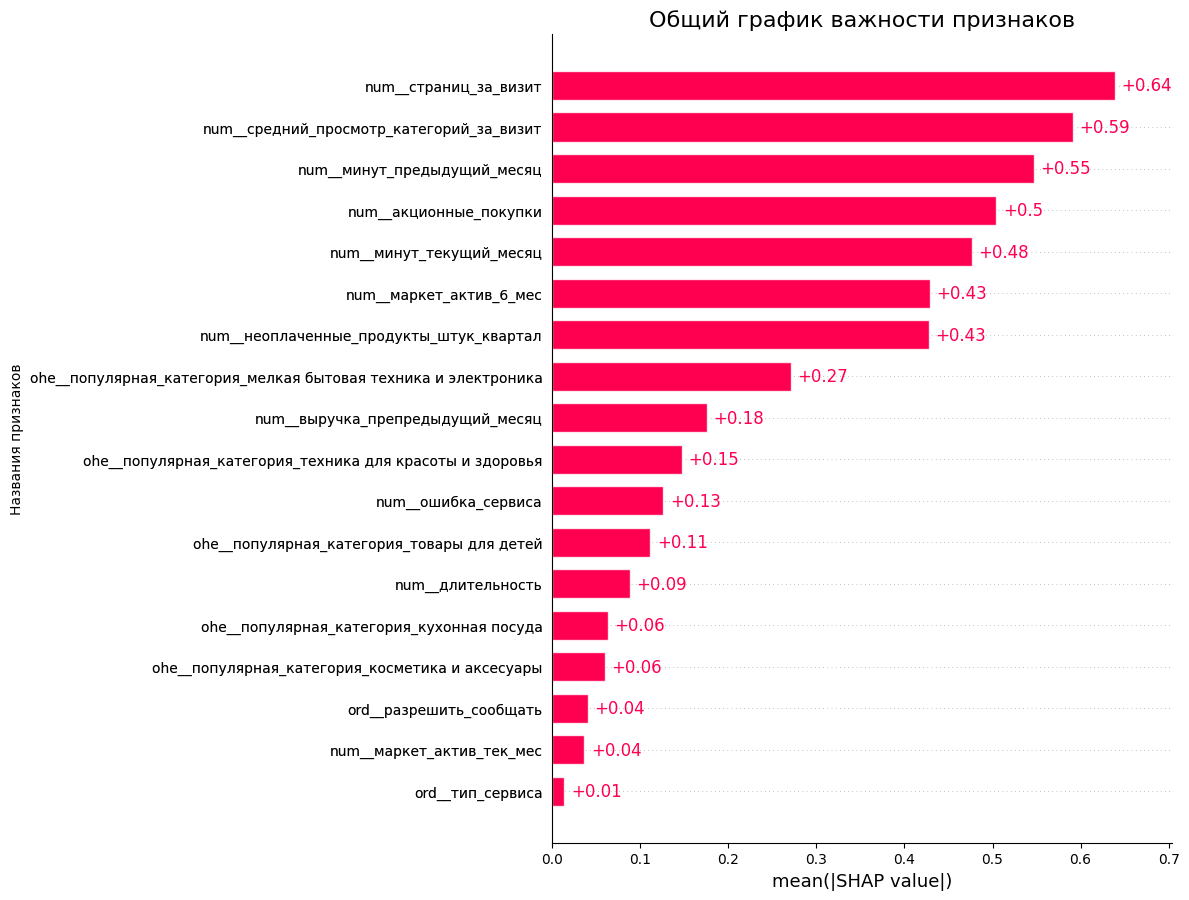

In [103]:
shap.plots.bar(shap_values, max_display=18, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_title('Общий график важности признаков', fontsize=16)

cb_ax = fig.axes[0] 

cb_ax.tick_params(labelsize=10)
cb_ax.set_ylabel("Названия признаков", fontsize=10)

plt.show()

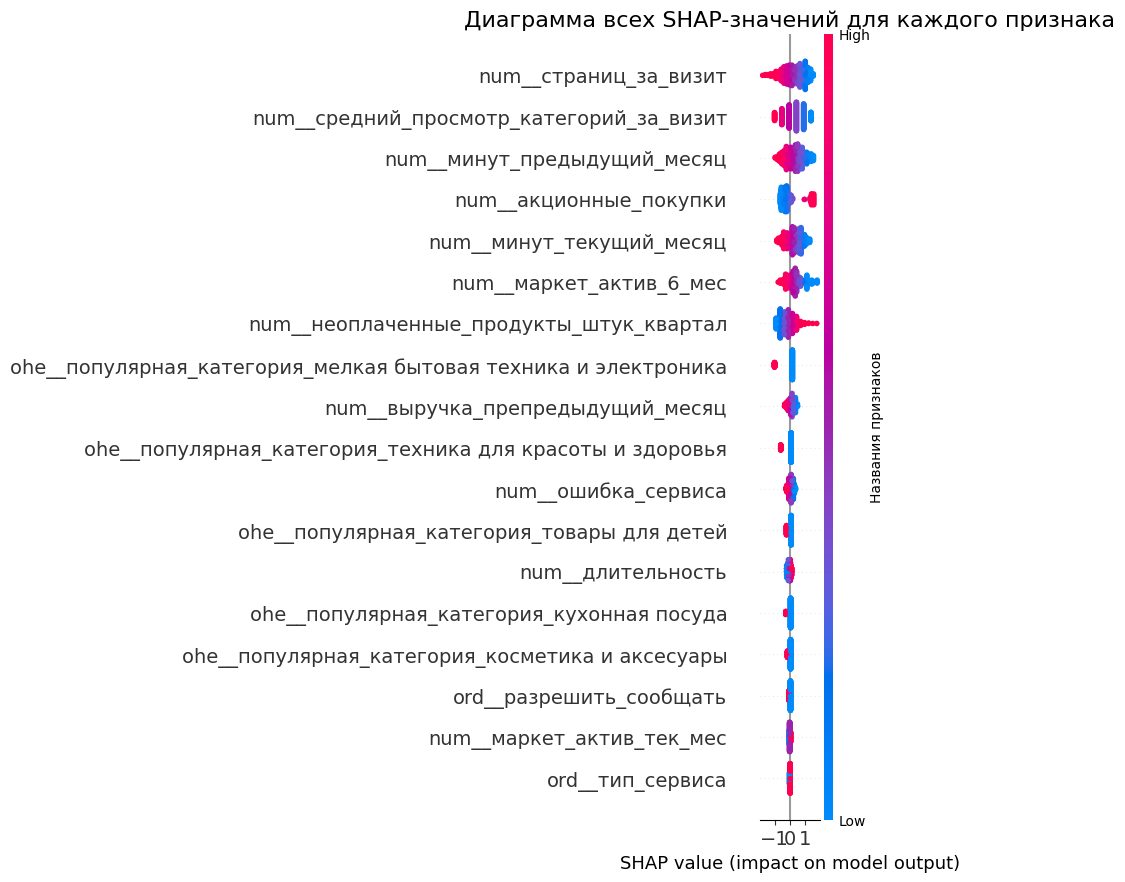

In [104]:
shap.summary_plot(shap_values, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_title('Диаграмма всех SHAP-значений для каждого признака', fontsize=16)

cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=10)
cb_ax.set_ylabel("Названия признаков", fontsize=10)

plt.show()

**Итоги раздела:**
* для модели мало значимы следующие признаки: Тип сервиса Стандарт, Разрешить сообщать Нет и Маркетинг активный текущий месяц;
* сильнее всего влияют на целевой признак Средний просмотр категорий за визит и Страниц за визит, а так же выручка за Позапрошлый месяц и Акционные покупки;
* исходя из результатов исследования сильнее всего стоит сосредоточиться над увеличением Просмотра категорий за визит и Страниц, так как именно эти признаки сильнее всего влияют на целевой. Например можно лучше настроить рекомендательную ленту и предлагать товары из нескольких категорий;
* так же покупателям "в зоне риска" стоит предлагать больше товаров по акции.

## 8 Шаг. Сегментация покупателей

In [107]:
# Объединение общей таблицы с таблицей о прибыли покупателей
all_df = all_df.join(money, on='id')
all_df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдyщий_месяц,минут_текущий_месяц,прибыль
id,,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,3.13
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,3.95


In [108]:
# Функция для сегментации покупателей
def segmentation(row):
    if row['акционные_покупки'] > 0.75 and row['покупательская_активность'] == 'снизилась':
        return 'Акционные покупки, снижение'
    elif row['популярная_категория'] in ['техника для красоты и здоровья', 'мелкая бытовая техника и электроника']:
        return 'Длинный жизненный цикл'
    elif row['популярная_категория'] in ['товары для детей', 'домашний текстиль', 'косметика и аксесуары']:
        return 'Товары для себя или детей'
    elif row['покупательская_активность'] == 'снизилась' and row['прибыль'] > 5:
        return 'Высокая прибыль, снижение'
    else:
        return 'Другое'

all_df['сегмент'] = all_df.apply(segmentation, axis=1)

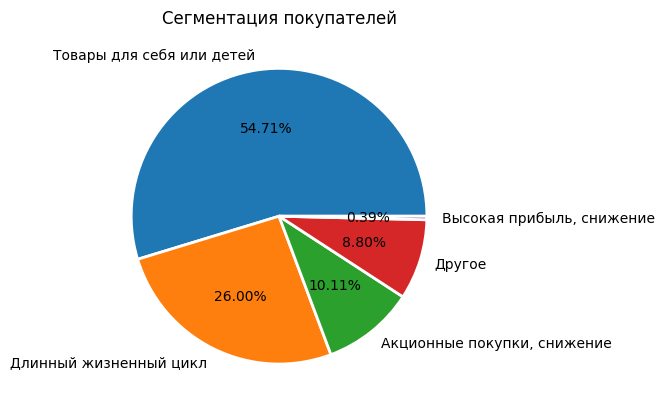

In [109]:
segment_pie = all_df['сегмент'].value_counts()
plt.pie(segment_pie, labels=segment_pie.index, autopct='%1.2f%%', wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'})
plt.title('Сегментация покупателей')
plt.show()

Для более подробного исследования я выберу группу покупателей со снизившейся активностью и высокой долей покупок по акции, так как удержать таких клиентов и являлось целью исследования.

In [111]:
# Выделение сегмента для более подробного исследования
segment = all_df.query('сегмент == "Акционные покупки, снижение"')
segment.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдyщий_месяц,минут_текущий_месяц,прибыль,сегмент
id,,,,,,,,,,,,,,,,,,,
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87,"Акционные покупки, снижение"
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21,"Акционные покупки, снижение"
215364,снизилась,премиум,да,4.3,4,708,0.98,домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11.0,9.0,2.67,"Акционные покупки, снижение"
215365,снизилась,стандарт,да,3.9,4,167,0.95,техника для красоты и здоровья,6,4,2,5,4577.0,4190.0,4799.3,6.0,10.0,3.65,"Акционные покупки, снижение"
215373,снизилась,премиум,нет,3.8,3,811,0.90,товары для детей,2,5,5,3,4632.0,4293.0,5161.1,10.0,8.0,3.69,"Акционные покупки, снижение"


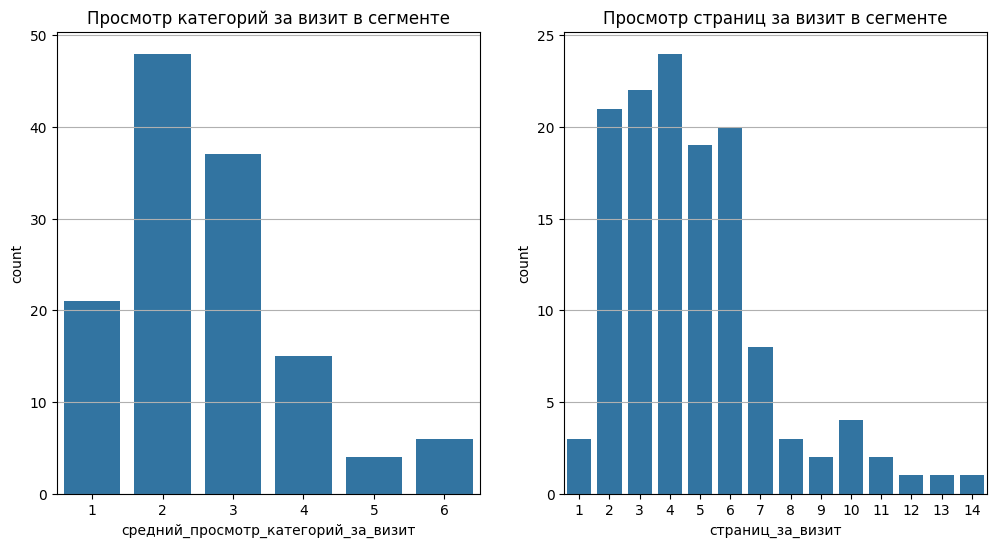

In [112]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(data=segment, x='средний_просмотр_категорий_за_визит', ax=ax[0])
ax[0].set_title('Просмотр категорий за визит в сегменте')
ax[0].grid(axis='y')

sns.countplot(data=segment, x='страниц_за_визит', ax=ax[1])
ax[1].set_title('Просмотр страниц за визит в сегменте')
ax[1].grid(axis='y')

plt.show()

Исходя из исследования выше два самых главных признака, которые влияют на Покупательскую активность это Средний просмотр категорий за визит и Средний просмотр страниц за визит. В выбранном сегменте показатели этих признаков очень низкие, значит стоит улучшать рекомендации и увеличивать количество показываемых категорий для данных пользователей.

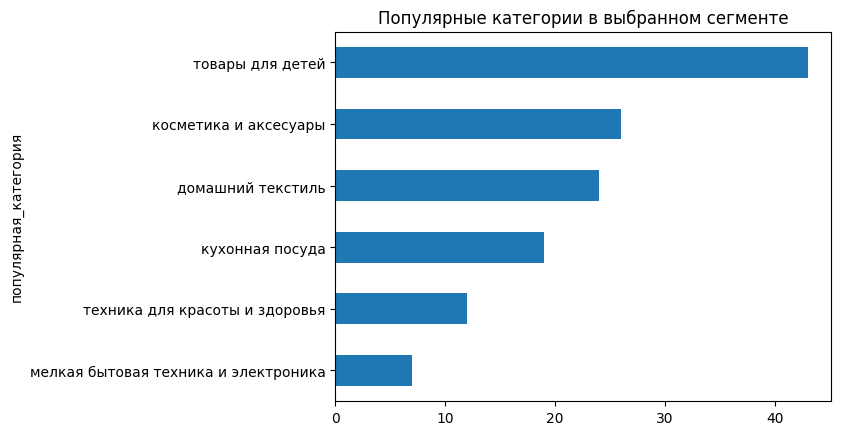

In [114]:
sort_categories = segment['популярная_категория'].value_counts(ascending=True)
sort_categories.plot(kind='barh')
plt.title('Популярные категории в выбранном сегменте')
plt.show()

С большим отрывом лидирует категория Товары для детей, значит именно её можно больше рекомендовать покупателям из выбранного сегмента. Так же им могут быть интересны категории Косметика и аксессуары, Домашний текстиль и Кухонная посуда.

**Итоги раздела:**
* покупатели были разделены на сегменты: `'Товары для себя или детей'`, `'Акционные покупки, снижение'`, ` 'Длинный жизненный цикл`',` 'Другое`',` 'Высокая прибыль, снижение`;
* для более детального исследования был выбран сегмент со снижением активности и большой долей покупок товаров по акции `'Акционные покупки, снижение'`;
* было установлено, что два самых важных признака, влияющих на Покупательскую активность, это Средний просмотр категорий за визит и Средний просмотр страниц за визит, в выбраном сегменте имеют очень низкие показатели;
* самой популярной категорией товаров в выбранном сегменте являются Товары для детей, так же высокие показатели имеют Косметика и аксессуары, Домашний текстиль и Кухонная посуда;
* в качестве рекомендаций можно выделить больше показов товаров из категорий Для детей, Косметика и аксессуары, Домашний текстиль и Кухонная посуда;
* так как в выбранном сегменте покупатели отдают предпочтение покупкам по акции, то можно подготовить для них специальные предложения со скидками на товары из категорий Для детей, Косметика и аксессуары, Домашний текстиль и Кухонная посуда.'

## 9 Шаг. Общий вывод

### 9.1 В этом проекте я проделала следующую работу:

1. Загрузила и изучила данные из файлов `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`.
2. Названия столбцов приведены к змеиному регистру.
3. Обнаружены и удалены опечатки в названиях категориальных признаков.
4. Был обнаружен и удалён выброс в датафейме `market_money`.
5. Проведён исследовательский анализ всех признаков во всех датафреймах.
6. Данные в датафреймах были сгруппированы и объединены в один общий.
7. Проведён корреляционный анализ количественных признаков.
8. Построен общий папйплайн для 4-х типов моделей МО.
9. Определена лучшая модель.
10. Посчитана метрика ROC-AUC для лучшей модели.
11. Произведён анализ важности признаков лучшей модели и построен график важности с помощью метода SHAP.
13. Покупатели были разделены на сегменты: `'Товары для себя или детей'`, `'Акционные покупки, снижение'`, `'Длинный жизненный цикл'`, `'Другое'`, `'Высокая прибыль, снижение`.
14. Был отобран и проанализирован сегмент со снижением активности и большой долей покупок товаров по акции: `'Акционные покупки, снижение'`.
15. Были даны рекомендации по повышению покупательской активности в выбранном сегменте.

### 9.2 На основании проделанной работы можно сделать следующие выводы:

* данные в датафреймах соответствуют описанию и не имеют пропусков;
* покупательская активность снизилась у почти 40% покупателей за прошедший период;
* в топе популярных категорий находятся Товары для детей, Домашний текстиль и Косметика и аксессуары;
* пользователи с низкой покупательской активностью просматривают меньше категорий товаров за визит(всего 2-3), в отличие от обычных пользователей(в основном 3-5 категорий);
* согласие или отказ от получения рекламы не вляет на покупательскую активность;
* в целом между количественными признаками наблюдается слабая корреляция, кое-где даже отрицательная;
* высокая корреляция имеется только между признаками Выручка за предыдущий месяц и Выручка за текущий месяц (0.80);
* мультиколлинеарности между количественными признаками нет;
* лучшей моделью оказалась `Логистическая регрессия` с гиперпараметрами `C=3`, `penalty='l1'`, `solver='liblinear'`;
* метрика ROC-AUC лучшей модели на тренировочной выборке: 0.90; 
* метрика ROC-AUC лучшей модели на тестовой выборке: 0.92;
* для модели мало значимы следующие признаки: Тип сервиса Стандарт, Разрешить сообщать Нет и Маркетинг активный текущий месяц;
* сильнее всего влияют на целевой признак Средний просмотр категорий за визит и Страниц за визит, а так же выручка за Позапрошлый месяц и Акционные покупки;
* было установлено, что два самых важных признака, влияющие на Покупательскую активность, это Средний просмотр категорий за визит и Средний просмотр страниц за визит, в выбраном сегменте имеют очень низкие показатели;
* самой популярной категорией товаров в выбранном сегменте являются Товары для детей, так же высокие показатели имеют Косметика и аксессуары, Домашний текстиль и Кухонная посуда.

### 9.3 Рекомендации:

1. Для сегмента покупателей со снизившейся Покупательской активностью и высокой долей покупок по акции следует лучше настроить рекомендательную ленту и добавить туда товаров из популярных категорий, а именно Для детей, Косметика и аксессуары, Домашний текстиль и Кухонная посуда.
2. Разработать персонализированные скидочные предложения из товаров популярных категорий.